## 加载Boston房价数据

In [1]:
from keras.datasets import boston_housing

(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()

Using TensorFlow backend.


In [2]:
train_data.shape

(404, 13)

In [3]:
test_data.shape

(102, 13)

In [4]:
train_targets

array([15.2, 42.3, 50. , 21.1, 17.7, 18.5, 11.3, 15.6, 15.6, 14.4, 12.1,
       17.9, 23.1, 19.9, 15.7,  8.8, 50. , 22.5, 24.1, 27.5, 10.9, 30.8,
       32.9, 24. , 18.5, 13.3, 22.9, 34.7, 16.6, 17.5, 22.3, 16.1, 14.9,
       23.1, 34.9, 25. , 13.9, 13.1, 20.4, 20. , 15.2, 24.7, 22.2, 16.7,
       12.7, 15.6, 18.4, 21. , 30.1, 15.1, 18.7,  9.6, 31.5, 24.8, 19.1,
       22. , 14.5, 11. , 32. , 29.4, 20.3, 24.4, 14.6, 19.5, 14.1, 14.3,
       15.6, 10.5,  6.3, 19.3, 19.3, 13.4, 36.4, 17.8, 13.5, 16.5,  8.3,
       14.3, 16. , 13.4, 28.6, 43.5, 20.2, 22. , 23. , 20.7, 12.5, 48.5,
       14.6, 13.4, 23.7, 50. , 21.7, 39.8, 38.7, 22.2, 34.9, 22.5, 31.1,
       28.7, 46. , 41.7, 21. , 26.6, 15. , 24.4, 13.3, 21.2, 11.7, 21.7,
       19.4, 50. , 22.8, 19.7, 24.7, 36.2, 14.2, 18.9, 18.3, 20.6, 24.6,
       18.2,  8.7, 44. , 10.4, 13.2, 21.2, 37. , 30.7, 22.9, 20. , 19.3,
       31.7, 32. , 23.1, 18.8, 10.9, 50. , 19.6,  5. , 14.4, 19.8, 13.8,
       19.6, 23.9, 24.5, 25. , 19.9, 17.2, 24.6, 13

## 数据标准化

将取值范围差异很大的数据输入到神经网络中，这是有问题的。网络可能会自动适应这种取值范围不同的数据，但学习肯定变得更加困难。对于这种数据，普遍采用的最佳实践是对每个特征做标准化，即对输入数据的每个特征（输入数据矩阵中的列），减去特征平均值，再除以标准差，这样得到的特征平均值为0，标准差为1。

In [5]:
mean = train_data.mean(axis=0)
train_data -= mean
std = train_data.std(axis=0)
train_data /= std

test_data -= mean
test_data /= std

## 模型定义

In [6]:
from keras import models
from keras import layers

def build_model():
    model = models.Sequential() # 因为需要将同一个模型多次实例化，所以用一个函数来构建模型
    model.add(layers.Dense(64, activation='relu', input_shape=(train_data.shape[1],)))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1))
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    return model

网络的最后一层只有一个单元，没有激活，是一个线性层。这是标量回归（标量回归是预测单一连续值得回归）的典型设置。添加激活函数将会限制输出范围。例如，如果向最后一层添加sigmoid激活函数，网络只能学会预测0~1范围内的值。这里最后一层是纯线性的，所以网络可以学会预测任意范围内的值。

注意，编译网路用的是mse损失函数，即 __均方误差（MSE，mean squared error）__ ，预测值与目标值之差得平方。这是回归问题常用的损失函数。

在训练过程中还监控一个新指标： __平均绝对误差（MAE，mean absolute error）__ 。它是预测值与目标值之差的绝对值。比如，如果这个问题的 MAE 等于 0.5，就表示你预测的房价与实际价格平均相差 500 美元。

## K折验证

In [7]:
import numpy as np

k = 4
num_val_samples = len(train_data) // k
num_epochs = 100
all_scores = []

for i in range(k):
    print('processing fold #', i)
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples] # 准备验证数据：第k个分区的数据
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]
    
    partial_train_data = np.concatenate( # 准备训练数据：其他所有分区的数据
        [train_data[:i * num_val_samples],
         train_data[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
         [train_targets[:i * num_val_samples],
          train_targets[(i + 1) * num_val_samples:]],
         axis=0)
    
    model = build_model() # 构建 Keras 模型（已编译）
    model.fit(partial_train_data, partial_train_targets, # 训练模型（静默模式，verbose=0）
              epochs=num_epochs, batch_size=1, verbose=1)
    val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=1) # 在验证数据上评估模型
    all_scores.append(val_mae)

processing fold # 0
Epoch 1/100
303/303 [==============================] - 3s 10ms/step - loss: 202.3814 - mean_absolute_error: 10.7722
Epoch 2/100
303/303 [==============================] - 1s 4ms/step - loss: 30.2373 - mean_absolute_error: 3.8334
Epoch 3/100
303/303 [==============================] - 1s 4ms/step - loss: 21.3092 - mean_absolute_error: 3.1753
Epoch 4/100
303/303 [==============================] - 1s 4ms/step - loss: 18.2486 - mean_absolute_error: 2.8959
Epoch 5/100
303/303 [==============================] - 1s 4ms/step - loss: 16.6024 - mean_absolute_error: 2.6640
Epoch 6/100
303/303 [==============================] - 1s 4ms/step - loss: 15.4888 - mean_absolute_error: 2.5713
Epoch 7/100
303/303 [==============================] - 1s 4ms/step - loss: 14.2158 - mean_absolute_error: 2.5346
Epoch 8/100
303/303 [==============================] - 1s 4ms/step - loss: 13.8676 - mean_absolute_error: 2.4219
Epoch 9/100
303/303 [==============================] - 1s 4ms/step - loss

In [8]:
all_scores

[2.0956787838794217, 2.220593797098292, 2.859968412040484, 2.40535704039111]

In [9]:
np.mean(all_scores)

2.3953995083523267

每次运行模型得到的验证分数有很大差异，从2.6到3.2不等。平均分数（3.0）是比单一分数更可靠的指标——这就是K折交叉验证的关键。在这个例子中，预测的房价与实际价格平均相差3000美元，考虑到实际价格范围在10000~50000美元，这一差别还是很大的。

## 保存每折的验证结果

我们让训练时间更长一点，达到500个轮次。为了记录模型在每轮的表现，我们需要修改训练循环，以保存每轮的验证分数记录。

In [10]:
num_epochs = 500
all_mae_histories = []

for i in range(k):
    print('processing fold #', i)
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples] # 准备验证数据：第k个分区的数据
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]
    
    partial_train_data = np.concatenate( # 准备训练数据：其他所有分区的数据
        [train_data[:i * num_val_samples],
         train_data[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
         [train_targets[:i * num_val_samples],
          train_targets[(i + 1) * num_val_samples:]],
         axis=0)
    
    model = build_model() # 构建 Keras 模型（已编译）
    history = model.fit(partial_train_data, partial_train_targets, # 训练模型（静默模式，verbose=0）
                        validation_data=(val_data, val_targets),
                        epochs=num_epochs, batch_size=1, verbose=0)
    mae_history = history.history['val_mean_absolute_error']
    all_mae_histories.append(mae_history)

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


## 计算所有轮次中的 K 折验证分数平均值

In [41]:
average_mae_history = [np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

## 绘制验证分数

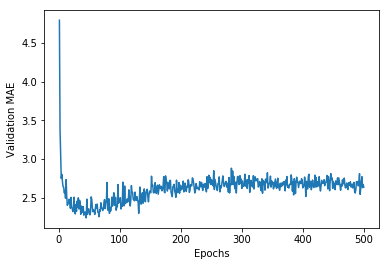

In [44]:
import matplotlib.pyplot as plt

plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

因为纵轴的范围较大，且数据方差相对较大，所以难以看清这张图的规律。我们来重新绘制一张图。
* 删除前10个数据点，因为它们的取值范围与曲线上的其他点不同
* 将每个数据点替换为前面数据点的指数移动平均值，以得到光滑的曲线

## 绘制验证分数（删除前 10 个数据点）

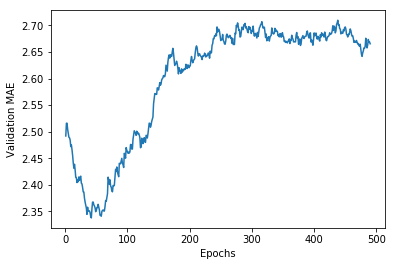

In [45]:
def smooth_curve(points, factor=0.9):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

smooth_mae_history = smooth_curve(average_mae_history[10:])

plt.plot(range(1, len(smooth_mae_history) + 1), smooth_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

从上图可以看出，验证 MAE 在 80 轮后不再显著降低，之后就开始过拟合。

## 训练最终模型

In [47]:
model = build_model()  # 一个全新的编译好的模型
model.fit(train_data, train_targets, epochs=80, batch_size=16, verbose=0) # 在所有训练数据上训练模型
test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)

102/102 [==============================] - 0s 2ms/step


In [48]:
test_mae_score

3.1331147119110705

我们预测的房价还是和实际价格相差约 3100 美元